## FINAL-ANSWERS Fetch Catalog Technical Challenge - Andrew Byrnes

This notebook contains the final version of my answers to the Fetch Catalog Analyst Technical Challenge.

The first part of the challenge (uploading the provided CSV files to a database engine) is presented in 1-Data_Prep.ipynb. I used SQLite to create catalog.db, the input to for this notebook's analysis. 

The third notebook, 2.1-EDA-first-pass.ipynb, contains a first draft of my approach to these questions. It is not a polished final product, but reflects my approach to working through this exercise.

### Data Sources
- catalog.db : SQLite file from notebook 1-Data_Prep

### Changes
- 09-08-2022 : compiled final answers
- 09-09-2022 : submitted 

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from os import path
import sqlite3
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import re
# surpress the benign warning from fuzzywuzzy 
import warnings
warnings.filterwarnings("ignore", message="Using slow pure-python SequenceMatcher")
from fuzzywuzzy import fuzz

### File Locations

In [2]:
db_path = Path.cwd() / "data" / "processed" / "catalog.db"
fetch_logo = Path.cwd() / "data" / "raw" / "fetch.jpg"

### Formatting

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')

### Catalog.db schema  

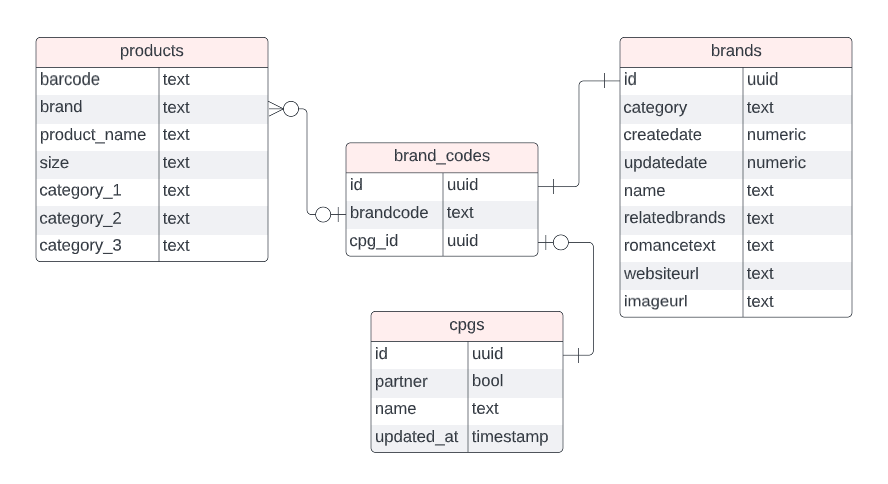
*provided schema

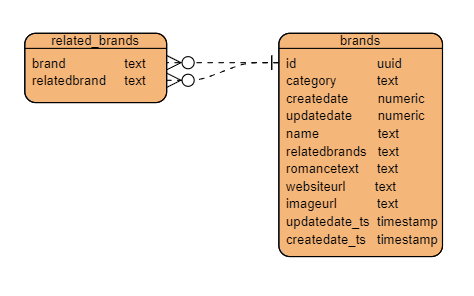
*modified brands table with additional columns; updatedate_ts & createdate_ts and additional related_brands table present in catalog.db

# General questions

## 1) What are your general observations about the quality & completeness of the data included in this challenge?

In addition to the following, I've included some specific observations about this data in my question 2 answer.  

I haven't noticed inconsistent formating of values within any of these table's columns. I did notice some incompleteness in the data - most notebaly it appears that the brand_code and brands tables do not contain a complete set of brand information. There are 262 brands represented on the brands table and 343 unique brands on the product table. This significantly impacts the ability to perform analysis on all of the products in the products table.

I'm not sure of the reason for a brand_codes table, it seems that brand_codes.brandcode and brand_codes.cpg_id could live on the brands table without impacting any of the possible joins. Potentially there would be a performance impact to joining products to cpgs via the brands table that has more columns than brand_codes, I wouldn't imagine that would be noticeble with the size of the data for this exercise. 

I thought it odd that there were null values in the cpgs.partner boolean column, especially given that there are both True and False values present. If there were only True values present, one might assume that null implied falseness. As it stands I'm left thinking there is some missing data here.

All of the records on the cpgs were updated at the same time: 2022-07-08 12:36:42.733.

On the brands table, the oldest record's createdate was 2018-06-06 21:06:35.510 and newest 2021-10-19 19:07:00.364. The oldest updatedate was 2021-07-14 12:55:40.855 and newest 2021-10-19 19:10:01.472. The 9 month gap between the most recent brands table update and cpgs update could be more evidence that the brands table is missing data / out of date.

In [4]:
query = f"""
    with distinct_brands as
    (
    select 
        distinct(brand)
    from
        products
    )
    select
        count(*) as unique_product_brands
    from
        distinct_brands
    """

#execute the queries above and save results to dataframes corresponding dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df

,unique_product_brands
0,343


In [5]:
query = f"""
    select
        min(createdate_ts) as min_createdate,
        max(createdate_ts) as max_createdate,
        min(updatedate_ts) as min_updatedate,
        max(updatedate_ts) as max_updatedate
    from
        brands
    """

#execute the queries above and save results to dataframes corresponding dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df

,min_createdate,max_createdate,min_updatedate,max_updatedate
0,2018-06-06 21:06:35.510000,2021-10-19 19:07:00.364000,2021-07-14 12:55:40.855000,2021-10-19 19:10:01.472000


In [6]:
query = f"""
    select
        min(updated_at) as min_update,
        max(updated_at) as max_update
    from
        cpgs
    """

#execute the queries above and save results to dataframes corresponding dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df

,min_update,max_update
0,2022-07-08 12:36:42.733000,2022-07-08 12:36:42.733000


## 2) Please develop 1-2 metrics that grade the quality of data presented in one of these tables. The `products` or `brands` tables are a good candidate for this.  

I assessed the data across two main areas - completeness and integrity. I also performed a spot check for validity of products.size which informed my approach to question 4.

For **completeness** I wanted to get a sense of how much data may be missing or unavailable, and if it was concentrated in any of the tables or specific fields. I wrote a python function (ref: 2a) that takes two arguemtns: db_path and table_name. It returns a simple printed report that includes the total records present in the table and two summary charts. The first chart describes the number of records that contain 0 null values up to 10. The second chart groups by table column and describes the number of records that have a null value in that column. Both summary tables also include a percentage column.

Observations from the results of the completeness_summary (ref:2b) preformed on all the tables:
- brands:
  - Contains the most null values of all the tables. 93.5% of the values in brands.relatedbrands are null. alone this doesn't suggest that data is missing, a null brands.relatedbrands value only implies there are no related brands.
  - 34% of records are missing an imageurl, and 31% are missing romance text. It seems likely that these columns are missing data
  - It's not clear what createdate describes, but it seems odd for that column to have any null values let alone 21%  
- brand_codes:
  - A very complete table with only 3 records (1%) missing values. the only column missing values is brand_codes.brandcode, but that is the column used to join to products - we can assume this is data that should exist.
- cpgs:
  - The only missing data is 44 boolean values in cpgs.partner. It would appear that a null value does not imply False as there are both True and False values present.
- products:
  - 21.6% of records are missing a products.size value. A quick look at products.product_name and products.category_1 where products.size is null suggests a value should be expected for most of these records.
  - Less than 1% of records are missing a products.category_3 value, which could be expected        

##

To get a sense of the **integrity** of the data I explored the effectiveness of the table joins to understand if and how many records would be orphaned/remain unmatched after the join. I wrote a series of common table expressions to emulate all the joins described in the provided schmea. I then joined all the CTEs by UNION to return a summary result set. (ref:2c)  

Observations from the results of this integrity check:
- products.brand (many or zero) TO (zero or one) brand_codes.brandcode:
  - 84.6% of the products records do not have a match on the brand table. This is alarming and significantly limits any anlysis of the data on the products that would benefit from the descripitive information found on the brands table.
- brand_codes.brandcode (zero or one) TO (many or zero) products.brand
  - When joining in the opposite direction from brand_codes to prodcuts, 78.5% of the records in brand_codes don't find a match on the products table. This may be ok, but if there is an assumption that every brand should have at least one assoicated product then this would suggest there is missing product data or an issue with one or both of the columns used in the join.
- cpgs.id (one) TO (one or zero) brand_codes.cpg_id
  - 46.5% of cpgs records do not match to brand_codes. When considered alongside the following, this might not suggest an error.
- brand_codes.cpg_id (one or zero) TO (one) cpgs.id
  - Every record in brand_codes matches to a record in cpgs. 
- brand_codes.id (one) TO (one) brands.id
  - There is only 1 record from brand_codes that doesn't match to brands.
- brands.id (one) TO (one) brand_codes.id 
  - All the records on brands have a match on brand_codes  

##

As I worked through question 4 I wanted to quickly get a sense of what values were present in products.size. Were the values of the expected type and content, in other words were the values **"valid"**. I chose to create a word cloud (ref: 2d) and at a glance determined that the majority, if not all, the values made sense contextually. 


### 2a

In [7]:
def completeness_summary(db_path, table_name):
    query = f"""
        select 
            *
        from
            {table_name}
    """
    #execute the above query and save results to dataframe 
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query(query, conn)
    conn.close()

    # create summary dataframes to be populated after translations
    columns_summary_df = pd.DataFrame()
    records_summary_df = pd.DataFrame()
    # variable for % calculations
    df_records = len(df.index)

    # convert values to boolean based on if NaN(null), sum across index axis 
    null_count_fields = df.isnull().sum(0)

    # add the index values (table column names) to the first column of columns_summary_df
    columns_summary_df['columns'] = pd.Series(null_count_fields.index.values.tolist())

    # add the counts of NaN(null) values to columns_summary_df
    columns_summary_df['null_values'] = pd.Series(null_count_fields.tolist())

    # add % of null fields in each column to columns_summary_df
    columns_summary_df['percent_null'] = columns_summary_df.null_values / df_records * 100
    columns_summary_df['percent_null'] = columns_summary_df['percent_null'].round(decimals = 1)

    # sort columns_summary_df by null_values decending 
    columns_summary_df = columns_summary_df.sort_values(by=['null_values'], ascending=False)


    # convert values to boolean based on if NaN(null), sum across columns axis 
    null_count_columns = df.isnull().sum(1)

    # prep dictionary to 
    records_w_null = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0}
        
    # populate records_w_null dict
    for key, value in records_w_null.items():
        for r in null_count_columns:
            if key == 0:
                if r == 0:
                    value += 1
            elif r >= key:
                value += 1
        records_w_null.update({key:value})

    # add the keys from records_w_null to the first column of records_summary_df
    col1 = []
    for key in records_w_null.keys():
        if key == 0:
            col1.append("0")
        else:
            col1.append(f"{key} or more")

    # add the keys from records_w_null to the first column of records_summary_df
    records_summary_df.insert(0,'fields_with_null_values',col1)           
    # add the values from records_w_null to the second column of records_summary_df
    records_summary_df.insert(1,'record_count',records_w_null.values()) 

    # add % of records with  in each column to columns_summary_df
    records_summary_df['record_percent'] = records_summary_df.record_count / df_records * 100
    records_summary_df['record_percent'] = records_summary_df['record_percent'].round(decimals = 1)


    # print summary report
    print(42*"#"+"\n"
        +f"""The {table_name} table has {df_records} records."""+2*"\n"
        +"The following summarizes the completeness of the record set by describing how many records"+"\n"
        "contain null values:"+2*"\n"
        +records_summary_df.to_string(index=False)+2*"\n"
        +"The following summarizes  total and % of null values in every column:"""+2*"\n"
        +columns_summary_df.to_string(index=False)+2*"\n"
        ++42*"#"+"\n"
         )

### 2b

In [8]:
completeness_summary(db_path, "brands")

##########################################
The brands table has 262 records.

The following summarizes the completeness of the record set by describing how many records
contain null values:

fields_with_null_values  record_count  record_percent
                      0            12             4.6
              1 or more           250            95.4
              2 or more           150            57.3
              3 or more           110            42.0
              4 or more            51            19.5
              5 or more            27            10.3
              6 or more             0             0.0
              7 or more             0             0.0
              8 or more             0             0.0
              9 or more             0             0.0
             10 or more             0             0.0

The following summarizes  total and % of null values in every column:

      columns  null_values  percent_null
relatedbrands          245          93.5
     im

In [9]:
completeness_summary(db_path, "brand_codes")

##########################################
The brand_codes table has 263 records.

The following summarizes the completeness of the record set by describing how many records
contain null values:

fields_with_null_values  record_count  record_percent
                      0           260            98.9
              1 or more             3             1.1
              2 or more             0             0.0
              3 or more             0             0.0
              4 or more             0             0.0
              5 or more             0             0.0
              6 or more             0             0.0
              7 or more             0             0.0
              8 or more             0             0.0
              9 or more             0             0.0
             10 or more             0             0.0

The following summarizes  total and % of null values in every column:

  columns  null_values  percent_null
brandcode            3           1.1
       id 

In [10]:
completeness_summary(db_path, "cpgs")

##########################################
The cpgs table has 300 records.

The following summarizes the completeness of the record set by describing how many records
contain null values:

fields_with_null_values  record_count  record_percent
                      0           256            85.3
              1 or more            44            14.7
              2 or more             0             0.0
              3 or more             0             0.0
              4 or more             0             0.0
              5 or more             0             0.0
              6 or more             0             0.0
              7 or more             0             0.0
              8 or more             0             0.0
              9 or more             0             0.0
             10 or more             0             0.0

The following summarizes  total and % of null values in every column:

   columns  null_values  percent_null
   partner           44          14.7
        id     

In [11]:
completeness_summary(db_path, "products")

##########################################
The products table has 1500 records.

The following summarizes the completeness of the record set by describing how many records
contain null values:

fields_with_null_values  record_count  record_percent
                      0          1174            78.3
              1 or more           326            21.7
              2 or more             0             0.0
              3 or more             0             0.0
              4 or more             0             0.0
              5 or more             0             0.0
              6 or more             0             0.0
              7 or more             0             0.0
              8 or more             0             0.0
              9 or more             0             0.0
             10 or more             0             0.0

The following summarizes  total and % of null values in every column:

     columns  null_values  percent_null
        size          324          21.6
  cate

In [12]:
completeness_summary(db_path, "related_brands")

##########################################
The related_brands table has 48 records.

The following summarizes the completeness of the record set by describing how many records
contain null values:

fields_with_null_values  record_count  record_percent
                      0            48           100.0
              1 or more             0             0.0
              2 or more             0             0.0
              3 or more             0             0.0
              4 or more             0             0.0
              5 or more             0             0.0
              6 or more             0             0.0
              7 or more             0             0.0
              8 or more             0             0.0
              9 or more             0             0.0
             10 or more             0             0.0

The following summarizes  total and % of null values in every column:

     columns  null_values  percent_null
       brand            0           0.0
re

## 2c

In [13]:
# Integrity - how many products are orphaned by not joining on p.brand <-> bc.brandcode?
query = f"""
    with p_to_bc as 
        (
        select
            "products.brand (many or zero) TO (zero or one) brand_codes.brandcode" as join_type,
            count(p_brand) as total_joinable_records_left_table,
            count(bc_brandcode) as records_matched,
            count(p_brand) - count(bc_brandcode) as records_orphaned,
            round(cast(count(p_brand) - count(bc_brandcode) as REAL) / count(p_brand) * 100, 2) as percentage_orphaned
        from
            ( 
            select
                p.brand as p_brand,
                bc.brandcode as bc_brandcode 
            from
                products p
                left join brand_codes bc on bc.brandcode = p.brand         
            )           
        ),
        
        bc_to_p as
        (
        select
            "brand_codes.brandcode (zero or one) TO (many or zero) products.brand" as join_type,
            count(bc_brandcode) as total_joinable_records_left_table,
            count(p_brand) as records_matched,
            count(bc_brandcode) - count(p_brand) as records_orphaned,
            round(cast(count(bc_brandcode) - count(p_brand) as REAL) / count(bc_brandcode) * 100, 2) as percentage_orphaned
        from
            (
            select
                bc.brandcode as bc_brandcode,
                p.brand as p_brand
            from
                brand_codes bc
                -- need just the distinct brands from product table for comparison
                left join (
                            select
                                distinct brand
                            from
                                products
                            ) p on p.brand = bc.brandcode
            )
        ),
        
        bc_to_b as
        (
        select
            "brand_codes.id (one) TO (one) brands.id" as join_type,
            count(bc.id) as total_joinable_records_left_table,
            count(b.id) as records_matched,
            count(bc.id) - count(b.id) as records_orphaned,
            round(cast(count(bc.id) - count(b.id) as REAL) / count(bc.id) * 100, 2) as percentage_orphaned
        from
            brand_codes bc
            left join brands b on b.id = bc.id
        ),
        
        b_to_bc as
        (
        select
            "brands.id (one) TO (one) brand_codes.id" as join_type,
            count(b.id) as total_joinable_records_left_table,
            count(bc.id) as records_matched,
            count(b.id) - count(bc.id) as records_orphaned,
            round(cast(count(b.id) - count(bc.id) as REAL) / count(b.id) * 100, 2) as percentage_orphaned
        from
            brands b
            left join brand_codes bc on bc.id = b.id
        ),
        
        bc_to_c as
        (
        select
            "brand_codes.cpg_id (one or zero) TO (one) cpgs.id" as join_type,
            count(bc.cpg_id) as total_joinable_records_left_table,
            count(c.id) as records_matched,
            count(bc.cpg_id) - count(c.id) as records_orphaned,
            round(cast(count(bc.cpg_id) - count(c.id) as REAL) / count(bc.cpg_id) * 100, 2) as percentage_orphaned
        from
            brand_codes bc
            left join cpgs c on c.id = bc.cpg_id
        ),
        
        c_to_bc as
        (
        select
            "cpgs.id (one) TO (one or zero) brand_codes.cpg_id" as join_type,
            count(c.id) as total_joinable_records_left_table,
            count(bc.cpg_id) as records_matched,
            count(c.id) - count(bc.cpg_id) as records_orphaned,
            round(cast(count(c.id) - count(bc.cpg_id) as REAL) / count(c.id) * 100, 2) as percentage_orphaned
        from
            cpgs c
            left join brand_codes bc on bc.cpg_id = c.id
        )
        
        select * from p_to_bc
        UNION
        select * from bc_to_p
        UNION
        select * from bc_to_b
        UNION
        select * from b_to_bc
        UNION
        select * from bc_to_c
        UNION
        select * from c_to_bc
        order by percentage_orphaned desc 
    """
#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df

,join_type,total_joinable_records_left_table,records_matched,records_orphaned,percentage_orphaned
0,products.brand (many or zero) TO (zero or one) brand_codes.brandcode,1500,231,1269,84.60
1,brand_codes.brandcode (zero or one) TO (many or zero) products.brand,260,56,204,78.46
2,cpgs.id (one) TO (one or zero) brand_codes.cpg_id,492,263,229,46.54
3,brand_codes.id (one) TO (one) brands.id,263,262,1,0.38
4,brand_codes.cpg_id (one or zero) TO (one) cpgs.id,263,263,0,0.00
5,brands.id (one) TO (one) brand_codes.id,262,262,0,0.00


## 2d

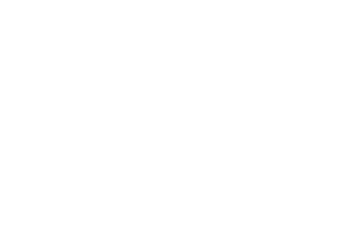

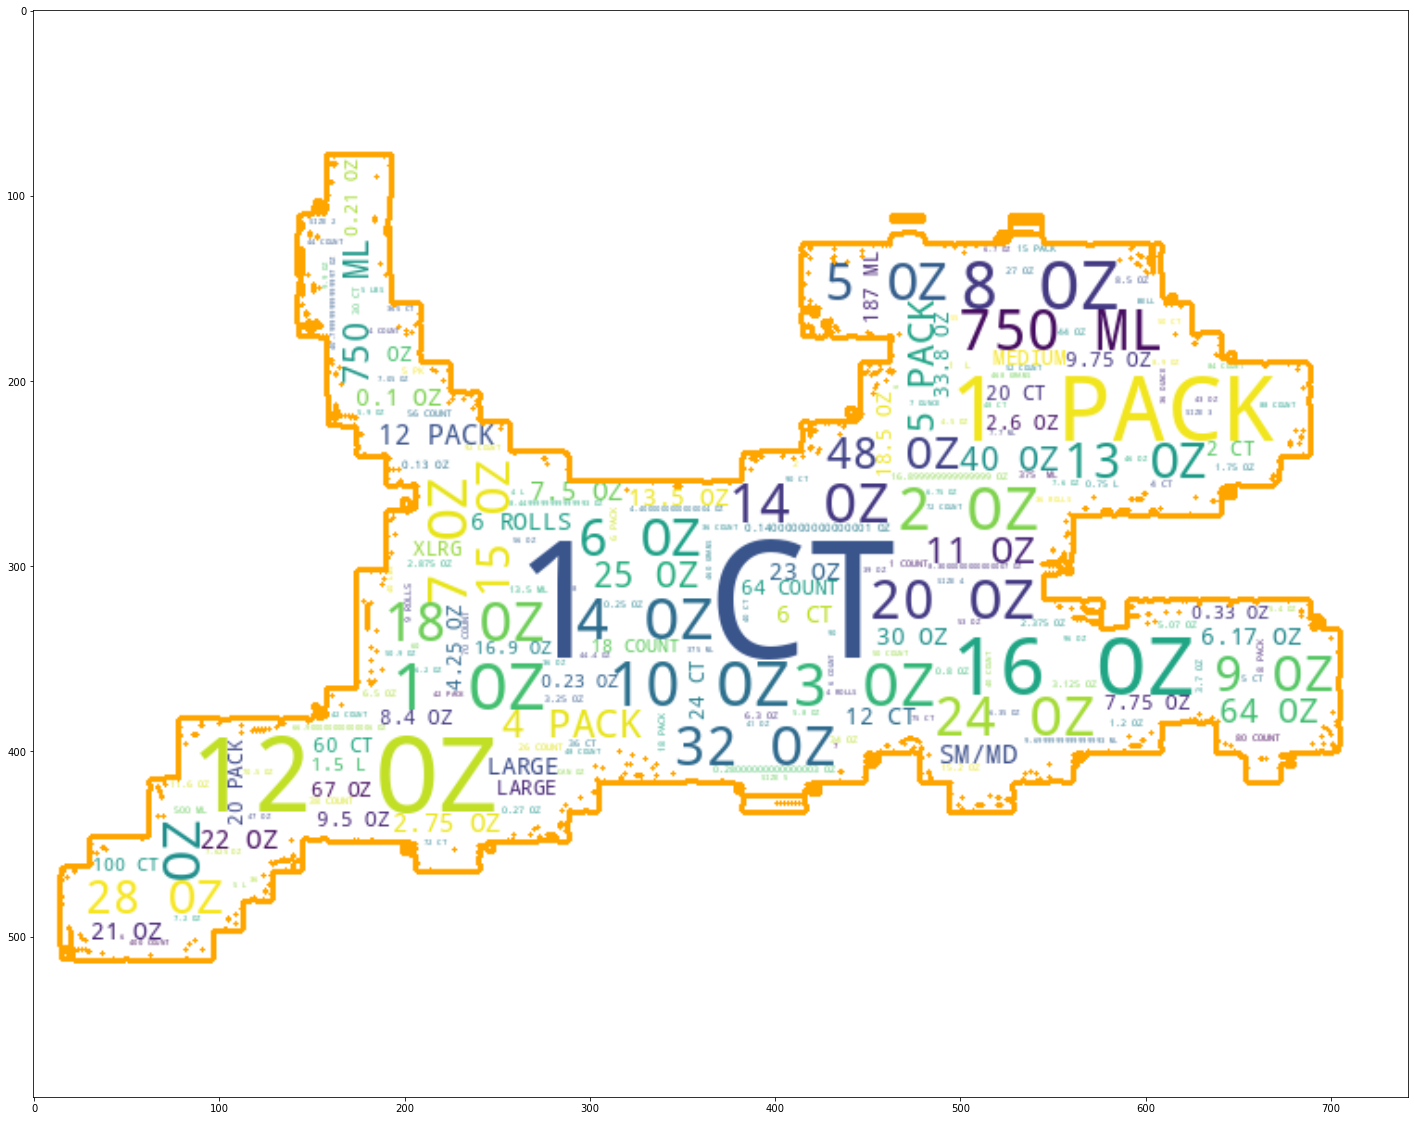

Top 20 values present in products.size and the count of records:

  size  records
  None      324
  1 CT      203
 12 OZ       56
             47
1 PACK       42
 16 OZ       34
  8 OZ       21
  1 OZ       20
 10 OZ       18
  3 OZ       17
  2 OZ       17
750 ML       16
  4 OZ       16
 20 OZ       15
  7 OZ       14
 32 OZ       14
 24 OZ       14
 18 OZ       14
 14 OZ       14
  6 OZ       13


In [14]:
# visualizing the values in products.size
# how frequently do the values in products.size occur
query = f"""
    select
        size,
        count(*) as records
    from
        products
    group by size
    order by records desc
    """

#execute the queries above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

# convert df to dict for word cloud using phrases, get rid of nulls(None) values
phrases_dict = df.dropna().set_index('size').to_dict()['records']

# show off a little bit by using the fetch logo for the word cloud shape
# converting jpg image to a numpy array
fetch_mask = np.array(Image.open(fetch_logo))
# generate word cloud object using the wordcloud libray 
wordcloud_fetch = WordCloud(background_color="white", width=800, height=400, mask=fetch_mask, contour_width=3, contour_color='orange').generate_from_frequencies(phrases_dict)

# Display the generated image with matplotlib:
plt.axis("off")
plt.figure( figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud_fetch, interpolation='bilinear')
plt.show()

# print a table of the top 20 values below the word cloud
print("Top 20 values present in products.size and the count of records:"+2*"\n"+df.head(20).to_string(index=False))

# Products-related questions  
*The following few questions can be solved by looking solely at the products table.*  

### 3) What are the most popular category-1, -2 & -3 combinations from the `products` table?  
The most popular 3-level combinations is COLOR COSMETICS:LIP:LIPSTICK with 48 records representing 3.2% of total products.  
This is followed by NAIL:NAIL:ENAMEL with 36 records/2.4% and PERSONAL WASH:BODY WASH:BODY WASH X ACNE with 33 records/2.2%. The rest of the 3-level combinations rank under 2%.   

### Does that ranking change if you only include the top 2 levels of categories? 
Yes. COLOR COSMETICS:LIP ranks 3rd of the top 2-level combinations at 75/5.8% (COSMETICS:LIP:LIPSTICK was first of 3-level combinations).  
NAIL:NAIL drops to 6th representing 2.4% (NAIL:NAIL:ENAMEL was second of 3-level combinations).  
PERSONAL WASH:BODY WASH drops to 7th representing 2.3% (PERSONAL WASH:BODY WASH:BODY WASH X ACNE was third of 3-level combinations).  
  
The most popular 2-level combinations is DAILY HAIR CARE:WASH & CARE with 87 records representing 5.8% of total records. Followed by FLNA:SALTY SNACKS with 79 records/5.3% and COLOR COSMETICS:LIP with 75 records/5.0%. The rest of the 2-level combinations rank under 5%.

At quick glance, personal care products appear to dominate the top 10 of both 3-level and 2-level granularities.  

### What if you only include the top level?
When gruoping by only category_1, COLOR COSMETICS ranks first by far with 188 records representing 12.5% of total products.  
LRB enters the top 5 rankings at second with 125 records/8.3%.  
DAILY HAIR CARE remains popular at third with 112 records/7.5%.

Categories related to personal care still remain very popular when bucketing at this granularity. 

In [15]:
# count all products grouping by the concatination of all 3 category columns 
query_123 = f"""
    select 
        category_1 || ':' || category_2 || ':' || category_3 as category_123
        , count(*) as records
    from
        products
    group by 1
    order by 2 desc
    """
# count all products grouping by the concatination of the first 2 category columns 
query_12 = f"""
    select 
        category_1 || ':' || category_2 as category_12
        , count(*) as records
    from
        products
    group by 1
    order by 2 desc
    """
# count all products grouping by top level cateogry column
query_1 = f"""
    select 
        category_1 as category_1
        , count(*) as records
    from
        products
    group by 1
    order by 2 desc
    """

#execute the queries above and save results to dataframes corresponding dataframes 
conn = sqlite3.connect(db_path)
df_123 = pd.read_sql_query(query_123, conn)
df_12 = pd.read_sql_query(query_12, conn)
df_1 = pd.read_sql_query(query_1, conn)
conn.close()

#add a % column to dataframes
df_123_sum_records = df_123['records'].sum()
df_123['record_percent'] = df_123['records'] / df_123_sum_records * 100
df_123['record_percent'] = df_123['record_percent'].round(decimals = 1)

df_12_sum_records = df_12['records'].sum()
df_12['record_percent'] = df_12['records'] / df_12_sum_records * 100
df_12['record_percent'] = df_12['record_percent'].round(decimals = 1)

df_1_sum_records = df_1['records'].sum()
df_1['record_percent'] = df_1['records'] / df_123_sum_records * 100
df_1['record_percent'] = df_1['record_percent'].round(decimals = 1)

print("Top 20 product categories grouping by the concatination of all 3 category columns:"+"\n")
print(df_123.head(20).to_string(index=False)+2*"\n")
print("Top 20 product categories grouping by the concatination of the first 2 category columns:"+"\n")
print(df_12.head(20).to_string(index=False)+2*"\n")
print("Top 20 product categories grouping by top level cateogry column:"+"\n")
print(df_1.head(20).to_string(index=False)+2*"\n")      

Top 20 product categories grouping by the concatination of all 3 category columns:

                                           category_123  records  record_percent
                           COLOR COSMETICS:LIP:LIPSTICK       48             3.2
                                       NAIL:NAIL:ENAMEL       36             2.4
               PERSONAL WASH:BODY WASH:BODY WASH X ACNE       33             2.2
 DAILY HAIR CARE:WASH & CARE:REGULAR/BASIC CONDITIONERS       26             1.7
      WOMENS HAIR COLOR:BASIC PERMANENT:BASIC PERMANENT       24             1.6
                                            LRB:CSD:CSD       23             1.5
                         COLOR COSMETICS:EYE:EYE SHADOW       23             1.5
                                   LRB:SPORTS DRINK:NCB       22             1.5
              PERSONAL WASH:BAR SOAP:BAR SOAP INCL FACE       20             1.3
                       FLNA:SALTY SNACKS:TORTILLA CHIPS       20             1.3
                         

## 4) How many products appear to have a mis-match between the size as listed in the size field and the text in the product field?

There are 1,500 records in the product table. (ref: 2b)
324 records have a null value for size, and 47 records had a blank string. Excluding those records leaves 1,129 records that could create a possible match.

After looking at the most common sizes (ref: 2d) I recgonized that the pattern for a size value is unit + value. The unit is a number or decimal followed by one of a relitively limited list of strings. ie 5 OZ, 20 CT. The task is to identify this size pattern within the product_name field.

I was able to match the pattern and extract a size from product_name for 664 records using regex.

Using the fuzzywuzzy library I compared the original size field to the extracted_size using the ratio method. The ratio method measures edit distance between two strings and returns a score, 100 being a perfect match. (ref 4a)

After a subjective review of the resulting scores, I determined that scores of 100 were a great match, scores >= 80 were a strong match, scores >= 70 a good match, scores >= 60 were questionable, and anything less than 60 was a poor or no match. I applied those conditions in a match_strength column. (ref: 4b)

With that in mind, I'm confident that there around **156 records with a definite mis-match, and including the questionable matches would increase that assessment to around 200.**

About 23% of records where I could compare the orignal and an extracted size from product_name contain a definite mis-match. Another 7% are likely mis-matched. About 56% have a perfect match, and another 13% I'm highly confident are a match. (ref: 4c)

## 4a

In [16]:
#query to pull size and product_name for comparison, exclude the 324 size is null or = ' ' records
query = f"""
    select 
        size,
        product_name
    from
        products
    where 
        size is not null
        and size <> ' '
    """
#execute the query above and save results to dataframe
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

# create a dataframe containing only the size column
sizes = pd.DataFrame()
sizes['size'] = df['size']

# create a list of the size column values stripping out numbers
just_alpha = []
for index, row in sizes.iterrows():
    alphas = re.sub(r'[^A-Za-z]', '', row['size'])
    just_alpha.append(alphas)

# only unique values
just_alpha = list(set(just_alpha))
# remove the ''
just_alpha.remove('')
# print(just_alpha)

# create a list of extracted size matchs from df['product_name']
extracted_sizes = []

# the most common size values share a pattern, number + string or value + unit - ie 5 OZ, 20 CT
# sometimes the number is a decimal
# the task is to find a unit preceded by a value in the product_name string

# regex partern to match the value preceeding a match of unit_regex
# \b : 'word boundry' 
# (\d+(?:\.\d+)?) : capturing group, a number one or more times, may include one . followed by a number one or more times
# \s+ : white space one or more times
value_regex = r'\b(\d+(?:\.\d+)?)\s+'

# regex pattern to match the unit part of a size - the 'alpha' portios 
# regex to match any of the values in just_alpha list
unit_regex = r'(' + '|'.join(just_alpha) + r')'

regex = value_regex + unit_regex 

for index, row in df.iterrows():
    sizes = re.findall(regex, row['product_name'])
    # only append the first tuple as a concated string, if no tuple None, if multiple tuples this process only 
    # retruns the first. opportunity to improve accuracy, but would need to create logic to choose  
    try:
        extracted_sizes.append(sizes[0][0]+' '+sizes[0][1])
    except:
        extracted_sizes.append(None)
    
# add extracted sizes to df
df['extracted_size'] = extracted_sizes

# # compare og size and extracted_size using fuzzywuzzy fuzz.ratio
fuzzy_scores = []

for index, row in df.iterrows():
    score = fuzz.ratio(row['size'], row['extracted_size'])
    fuzzy_scores.append(score)
    
# add ratio scores as a column on the dataframe
df['fuzzy_score'] = fuzzy_scores

filter = df['fuzzy_score']<101
df.sort_values('fuzzy_score', ascending=False).where(filter).dropna()

# anecedotaly everything above 80 is very strong, above 70 is good, above 60 questionable, below 60 bad

,size,product_name,extracted_size,fuzzy_score
564,18 OZ,SUAVE WASH SOAP PLASTIC BOTTLE RP 18 OZ,18 OZ,100
250,1 CT,AIR WCK VNL INDL WHT RND 30 HR GLS HLDR CNDL BOX 1 CT 006233885120,1 CT,100
634,22 OZ,AXE COOL METAL CLEANSING SHAMPOO LIQUID PLASTIC BOTTLE RP 22 OZ,22 OZ,100
260,0.8 OZ,RUFFLES POTATO CHIP BAKED CHEDDAR AND SOUR CREAM FLAVORED 0.8 OZ 1 CT,0.8 OZ,100
635,12 OZ,"CAFE ALTURA ORGANIC GROUND COFFEE DARK ROAST, 12 OZ",12 OZ,100
258,9.75 OZ,DORITOS TORTILLA CHIP ULTIMATE CHEDDAR 9.75 OZ 1 CT,9.75 OZ,100
256,32 OZ,TRESEMME 24 HOUR BODY HEALTHY VOLUME VOLUMIZING HAIR CONDITIONER LIQUID SP 32 OZ - 0022400623733,32 OZ,100
641,4 PACK,TOTINOS SUPREME PARTY PIZZA - 4 PACK,4 PACK,100
254,20 OZ,MTN DEW DEW S A SODA CHERRY RASPBRRY CTRS PLASTIC BOTTLE 20 OZ 1 CT,20 OZ,100
644,20 OZ,MTN DEW SODA DEW PLASTIC BOTTLE 20 OZ 1 CT,20 OZ,100


### 4b

In [17]:
# add a column to df to categorize the match score strength based on anecedotal observation
match_strength = []

for index, row in df.iterrows():
    if row['extracted_size'] is None:
        match_strength.append('Could not extract size')
    elif row['fuzzy_score'] == 100:
        match_strength.append('Great')
    elif row['fuzzy_score'] >= 80:
        match_strength.append('Strong')
    elif row['fuzzy_score'] >= 70:
        match_strength.append('Good')
    elif row['fuzzy_score'] >= 60:
        match_strength.append('Questionable')
    else:
        match_strength.append('Poor or no match')
        
# add match strength to df
df['match_strength'] = match_strength

filter = df['fuzzy_score']<101
df.sort_values('fuzzy_score', ascending=False).where(filter).dropna()

,size,product_name,extracted_size,fuzzy_score,match_strength
564,18 OZ,SUAVE WASH SOAP PLASTIC BOTTLE RP 18 OZ,18 OZ,100,Great
250,1 CT,AIR WCK VNL INDL WHT RND 30 HR GLS HLDR CNDL BOX 1 CT 006233885120,1 CT,100,Great
634,22 OZ,AXE COOL METAL CLEANSING SHAMPOO LIQUID PLASTIC BOTTLE RP 22 OZ,22 OZ,100,Great
260,0.8 OZ,RUFFLES POTATO CHIP BAKED CHEDDAR AND SOUR CREAM FLAVORED 0.8 OZ 1 CT,0.8 OZ,100,Great
635,12 OZ,"CAFE ALTURA ORGANIC GROUND COFFEE DARK ROAST, 12 OZ",12 OZ,100,Great
258,9.75 OZ,DORITOS TORTILLA CHIP ULTIMATE CHEDDAR 9.75 OZ 1 CT,9.75 OZ,100,Great
256,32 OZ,TRESEMME 24 HOUR BODY HEALTHY VOLUME VOLUMIZING HAIR CONDITIONER LIQUID SP 32 OZ - 0022400623733,32 OZ,100,Great
641,4 PACK,TOTINOS SUPREME PARTY PIZZA - 4 PACK,4 PACK,100,Great
254,20 OZ,MTN DEW DEW S A SODA CHERRY RASPBRRY CTRS PLASTIC BOTTLE 20 OZ 1 CT,20 OZ,100,Great
644,20 OZ,MTN DEW SODA DEW PLASTIC BOTTLE 20 OZ 1 CT,20 OZ,100,Great


## 4c

In [18]:
df.groupby('match_strength').size().sort_values(ascending=False)

match_strength
Could not extract size    465
Great                     371
Poor or no match          156
Good                       51
Questionable               47
Strong                     39
dtype: int64

## 5) For products with a null size value, how many products’ size can you extract from its name? Select these records in such a way that shows this size in a new column & removes it from the `product_name` field.

I was able to extract 146 product sizes from product_name.

When I chose SQLite, I hadn't realized it doesn't natively come with regex support. It is possible to add that support, but would likely require the reviewers of this notebook to install some non-standard packages to execute the code. In the interest of effecitively sharing this challege and code I opted to perform the transformations using regex with python and pandas.

I created a new table, products_size_extracted, that removes size values from product_name and shows them in a new column, extracted_size.



In [19]:
query = f"""
    select 
        *
    from
        products
    """
#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

# create a dataframe containing only the size column
sizes = pd.DataFrame()
sizes['size'] = df['size']

# # create a list of the size column stripping out numbers
just_alpha = []
for index, row in sizes.iterrows():
    #unlike q4 the query does not filter (size is not null and size <> ' ')
    try:
        alphas = re.sub(r'[^A-Za-z]', '', row['size'])
        just_alpha.append(alphas)
    except:
        pass
        
# only unique values
just_alpha = list(set(just_alpha))
# remove the ''
just_alpha.remove('')
# print(just_alpha)

# create a list of extracted size matchs from df['product_name']
extracted_sizes = []

# regex partern to match the value preceeding a match of unit_regex
value_regex = r'\b(\d+(?:\.\d+)?)\s+'

# regex to match any of the values in just_alpha list
unit_regex = r'(' + '|'.join(just_alpha) + r')'

regex = value_regex + unit_regex 

for index, row in df.iterrows():
    # only modify records where size is null(None) value
    if row['size'] is None:
        sizes = re.findall(regex, row['product_name'])
        # only append the first tuple as a concated string, if no tuple None
        try:
            extracted_sizes.append(sizes[0][0]+' '+sizes[0][1])
            # if a match is found, remove that pattern from the product_name string
            re.sub(regex, '', row['product_name'])
        except:
            extracted_sizes.append(None)
    else:
         extracted_sizes.append(None)

# add extracted_size to the data frame        
df['extracted_size'] = extracted_sizes


# upload table to database, select * where size is null

# create products_size_extracted table
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute('DROP TABLE IF EXISTS products_size_extracted')

c.execute("""CREATE TABLE IF NOT EXISTS products_size_extracted (
        barcode text UNIQUE,
        brand text,
        product_name text, 
        size text,
        category_1 text,
        category_2 text,
        category_3 text,
        extracted_size text
    )""")

df.to_sql('products_size_extracted', conn, if_exists='append', index=False)

conn.commit()
conn.close()

# Select these records in such a way that shows this size in a new column & removes it from the product_name field.
query = f"""
    select 
        *
    from
        products_size_extracted
    where
        extracted_size is not null
    """
#execute the query above and save results to dataframe
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

print(df.info())
print(2*'\n')
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   barcode         146 non-null    object
 1   brand           146 non-null    object
 2   product_name    146 non-null    object
 3   size            0 non-null      object
 4   category_1      146 non-null    object
 5   category_2      146 non-null    object
 6   category_3      146 non-null    object
 7   extracted_size  146 non-null    object
dtypes: object(8)
memory usage: 9.2+ KB
None





,barcode,brand,product_name,size,category_1,category_2,category_3,extracted_size
0,70923002009,TERRO,"TERRO READY-TO-USE LIQUID ANT KILLER, 2 OZ",None,HOUSEHOLD,INSECT & PEST CONTROL,INSECT & PEST CONTROL,2 OZ
1,41000004384,LIPTON,LIPTON STRAWBERRY WTRMELON ICED HERBAL TEA TEA CAFFEINE FREE 2 OZ - 0041000004382,None,TOTAL TEA,LEAF TEA,SPECIALTY,2 OZ
2,18000418275,PILLSBURY TOASTER STRUDEL,PILLSBURY TOASTER STRUDEL FROZEN SWEET CREAM CHEESE TOASTER STRUDEL 12.5 OZ - 0018000418271,None,FROZEN,PASTRIES,BREAKFAST PASTRIES,12.5 OZ
3,74323736502,MARINELA,"MARINELA GANSITO CHERRY SNACK CAKES, 8 COUNT, 1411 OZ",None,BAKED GOODS,MARINELA,CAKES,8 COUNT
4,72140030414,COPPERTONE,"COPPERTONE SPORT VALUE SPF 50 SUNSCREEN LOTION, 9.1 OZ",None,SUNCARE,SPORT SPF 50-69,SPORT,9.1 OZ
5,72437097014,BROMLEY,"BROMLEY ESTATE BLEND TEA BAGS, 12 PACKS OF 100CT (TOTAL 1200CT)",None,GROCERY,BEVERAGES,COFFEE & TEA,12 PACK
6,11111299085,DOVE,DOVE SHEA BUTTER SOAP 6 CT,None,PERSONAL WASH,BAR SOAP,BAR SOAP INCL FACE,6 CT
7,74323095265,MARINELA,"MARINELA GANSITO CHOCOLATE COVERED CREME & STRAWBERRY FILLED COOKIES TUBE, 10 COUNT",None,BAKED GOODS,MARINELA,COOKIES,10 COUNT
8,28400589222,SMARTFOOD,SMARTFOOD RTE POPCORN SPICY JALAPENO RANCH BAG .875 OZ,None,FLNA,SALTY SNACKS,RTE POPCORN,875 OZ
9,48500201473,TROPICANA,TROPICANA RASPBERRY LEMONADE DRINK NT FRM CNCNTRT PSTRZ PLASTIC BOTTLE 1 CT 12 OZ,None,LRB,J&D,NCB,1 CT


## 6) How many products appear to have a mis-match between its barcode and a UPC-like identifier in its name?

I was able to extract 205 UPC-like codes from the product_name field.  
None of my extracts were a perfect match to barcode.  
Using fuzzymatch ratio it appears that scores 87+ are strong matches (193 records) - typically the extract contains the barcode with some leading or trailing digits.  
**Below 87 are definite mismatches (12 records).**

In [20]:
query = f"""
    select 
        product_name,
        barcode
    from
        products
    """
#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

extracted_barcode = []
# create a list of barcodes extracted from product_ame using regex, search to only return the first match
for index, row in df.iterrows():
    code = re.search('\d{6,12}', row['product_name'])
    try:
        extracted_barcode.append(code[0])
    except:
        extracted_barcode.append(None)

df['extracted_barcode'] = extracted_barcode

# df.info() # extracted_barcode  205 non-null
# remove None values 
df.dropna(inplace=True)

df['perfect_match'] = df['barcode'] == df['extracted_barcode']

#check how many perfect matches occured, none...
df.groupby('perfect_match').size().sort_values(ascending=False)

# could do some logic, drop leading zeros, check length of barcode and trim from end until extracted_barcode matches length, then ==
# but fuzzywuzzy ratio method should give a good indication of matches without making assumptions about trimming leading or trailing digits
fuzzy_scores = []

for index, row in df.iterrows():
#     score = fuzz.partial_ratio(row['barcode'], row['extracted_barcode'])
    score = fuzz.ratio(row['barcode'], row['extracted_barcode'])
    fuzzy_scores.append(score)
    
# add scores as a column on the dataframe
df['fuzzy_score'] = fuzzy_scores

filter = df['fuzzy_score']<101
df.sort_values('fuzzy_score', ascending=False).where(filter)





,product_name,barcode,extracted_barcode,perfect_match,fuzzy_score
902,TIGI BED HEAD MINI HARD HEAD HAIR SPRAY SPRAY HOLDING RP 3 OZ - 2700733781971,2700733781976,270073378197,False,96
118,DOVE SHEA BUTTER WASH SOAP SQUEEZE BOTTLE RP 16.9 OZ - 8711700927591,8711700927598,871170092759,False,96
377,AXE STYLING ADRENALINE SPIKED UP LOOK EXTREME HOLD STYLING PUTTY PUTTY REGULAR HAIR STYLING PRODUCT RP 2.64 OZ - 2700719487601,2700719487601,270071948760,False,96
332,PONDS CREAM FACIAL MOISTURIZER DRY PLASTIC JAR RP 6.5 OZ - 2700714447462,2700714447464,270071444746,False,96
493,AXE COLLISION CUERO PLUS COOKIES BODY DEODORANT SPRAY FRESH 48 HOUR PLASTIC CONTAINER RP 5.07 OZ - 7791293034731,7791293034737,779129303473,False,96
587,DEGREE MEN MOTIONSENSE ULTRACLEAR BLACK + WHITE DEODORANT MOTIONSENSE 48 HOUR ALMNM ZRCNM TRCH G#1 PLASTIC CONTAINER RP 2.7 OZ - 2700714302631,2700714302633,270071430263,False,96
1386,DOVE MEN PLUS CARE ANTI PERSPIRANT COOL FRESH 48 HOUR PWRFL PRTCTN AEROSAL CAN RP 5.07 OZ - 8710908325731,8710908325731,871090832573,False,96
1205,SUAVE NATURALS CREAMY COCOA BUTTER & SHEA WASH SOAP PLASTIC BOTTLE RP 18 OZ - 2700718563661,2700718563665,270071856366,False,96
39,DOVE MEN PLUS CARE CLEAN COMFORT WASH SOAP PLASTIC BOTTLE PUMP RP 23.5 OZ - 2700715889241,2700715889249,270071588924,False,96
1119,MIRALAX ADULT LAXATIVES PEG PWD 40.8 OZ 40.8 OZ RP - 4110056454,41100564542,4110056454,False,95


In [21]:
filter = df['fuzzy_score']<101
num_records = len(df.where(filter).dropna())
print(f"There are {num_records} UPC-like codes in the records of the product_name field."+"\n")

filter = df['fuzzy_score'] == 100
num_records = len(df.where(filter).dropna())
print(f"There are {num_records} perfect matches (fuzzy_score of 100)."+"\n")

filter = df['fuzzy_score'] >= 87
num_records = len(df.where(filter).dropna())
print(f"There are {num_records} strong matches (fuzzy_score >= 87)."+"\n")

filter = df['fuzzy_score'] < 87
num_records = len(df.where(filter).dropna())
print(f"There are {num_records} definite mis-matches (fuzzy_score < 87)."+"\n")

There are 205 UPC-like codes in the records of the product_name field.

There are 0 perfect matches (fuzzy_score of 100).

There are 193 strong matches (fuzzy_score >= 87).

There are 12 definite mis-matches (fuzzy_score < 87).



# Questions spanning more than one table

## 7) How many products are associated with a recognized CPG partner? 

Assumption - I have assumed a cpgs.partner <> True is not a *recognized* CPG partner cpgs, and excluded those records via sql.  
There were 17 products that joined to a False value in cpgs.partner. 

**There are 214 products associated with a recognized CPG partner.**

## What are your observations about these partner products?
- 86% of associated products belong to the top 5 cpgs:
  - Kimberly Clark, 53 products, 24.8%
  - Pepsico, 41 products, 19.1%
  - General Mills, 39 products, 18.2%
  - MillerCoors, 27 products, 12.6%
  - Bimbo, 24 products, 11.2%
  - no other CPG has more than 4%

- Beverages and Baby are the two most popular brand categories of these products. Each with about 19% of the total. Followed by Beer, Hard Cider & Seltzer and Bread & Bakery with 13% and 11% repecitively. 

- Huggies is the brand with the most products associated wiht a cpgs partner with 40 products.




In [22]:
# create a view: v_cpg_partner_products
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute('DROP VIEW IF EXISTS v_cpg_partner_products')

c.execute("""CREATE VIEW IF NOT EXISTS v_cpg_partner_products AS
                select
                p.product_name
                , b.name as brand_name
                , p.category_1 as product_category_1
                , p.category_2 as product_category_2
                , p.category_3 as product_category_3
                , b.category as brand_category
                , b.createdate_ts as brands_createdate
                , c.name as cpgs_name
                , c.partner as cpgs_partner_bool

            from
                products p
                join brand_codes bc on bc.brandcode = p.brand
                join brands b on b.id = bc.id
                join cpgs c on c.id = bc.cpg_id

            where
                c.partner = True
            """)



query = f"""
    select
        *
    from
        v_cpg_partner_products
    order by 
        brand_category, brand_name, product_name
    """

#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df


,product_name,brand_name,product_category_1,product_category_2,product_category_3,brand_category,brands_createdate,cpgs_name,cpgs_partner_bool
0,HGS LTL SWM MDM DSPS SWMP DSNY PXR BAG 25 CT BOX W/BCH BL,Huggies,SWIM PANTS,SWIM PANTS,SPECIAL PK,Baby,2018-10-25 17:45:03.500000,Kimberly Clark,1
1,HGS PRMS BBY WP TUB LVND CHMM 64 CT,Huggies,TOTAL WIPES,BABY WIPES,FLUSHABLE WIPES,Baby,2018-10-25 17:45:03.500000,Kimberly Clark,1
2,HGS SPR SZ ONE MG DSPS DPR BAG LCNS TRDM IMG MLTP CLR WN PH DSNY 88 CT,Huggies,DIAPERS,POME,FEMININE WIPE,Baby,2018-10-25 17:45:03.500000,Kimberly Clark,1
3,HUGGIES DISPOSABLE DIAPER 100 COUNT,Huggies,DIAPERS,AB,GIANT,Baby,2018-10-25 17:45:03.500000,Kimberly Clark,1
4,HUGGIES DISPOSABLE DIAPER 172 COUNT,Huggies,DIAPERS,AB,HI,Baby,2018-10-25 17:45:03.500000,Kimberly Clark,1
5,HUGGIES DISPOSABLE DIAPER 28 COUNT,Huggies,DIAPERS,AB,JUMBO,Baby,2018-10-25 17:45:03.500000,Kimberly Clark,1
6,HUGGIES DISPOSABLE DIAPER 34 COUNT,Huggies,DIAPERS,AB,JUMBO,Baby,2018-10-25 17:45:03.500000,Kimberly Clark,1
7,HUGGIES DISPOSABLE DIAPER 40 COUNT,Huggies,DIAPERS,AB,MEGA,Baby,2018-10-25 17:45:03.500000,Kimberly Clark,1
8,HUGGIES DISPOSABLES DIAPER SIZE SIX OVER 35 POUND DISNEY TRADEMARK PREMOISTENED,Huggies,DIAPERS,AB,SPECIAL PK,Baby,2018-10-25 17:45:03.500000,Kimberly Clark,1
9,"HUGGIES LITTLE MOVERS DIAPER, 84 CT SIZE6",Huggies,DIAPERS,AB,HI CT/HUGE,Baby,2018-10-25 17:45:03.500000,Kimberly Clark,1


In [23]:
query = f"""
    select
        count(*)
    from
        v_cpg_partner_products
    """

#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df


,count(*)
0,214


In [24]:
query = f"""
    select
        brand_name,
        brand_category,
        cpgs_name,
        count(*) as products_count,
        round(cast(count(*) * 100 as REAL) / (select count(*) from v_cpg_partner_products), 2) as product_percentage
    from
        v_cpg_partner_products
    group by 
        brand_name, brand_category, cpgs_name
    order by
        products_count desc
    limit 
        10
    """

#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df

,brand_name,brand_category,cpgs_name,products_count,product_percentage
0,Huggies,Baby,Kimberly Clark,40,18.69
1,Mountain Dew,Beverages,Pepsico,19,8.88
2,Betty Crocker,Grocery,General Mills,16,7.48
3,Starbucks,Beverages,Pepsico,12,5.61
4,Nature Valley,Snacks,General Mills,11,5.14
5,Entenmann's,Bread & Bakery,Bimbo,10,4.67
6,Kleenex,Household,Kimberly Clark,9,4.21
7,Ticonderoga,Household,Ticonderoga,8,3.74
8,LARABAR,Snacks,General Mills,6,2.80
9,Fiber One,Health & Wellness,General Mills,5,2.34


In [25]:
query = f"""
    select
        brand_category,
        count(*) as products_count,
        round(cast(count(*) * 100 as REAL) / (select count(*) from v_cpg_partner_products), 2) as product_percentage
    from
        v_cpg_partner_products
    group by 
        brand_category
    order by
        products_count desc
    limit 
        10
    """

#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df

,brand_category,products_count,product_percentage
0,Beverages,41,19.16
1,Baby,40,18.69
2,"Beer, Hard Cider & Seltzer",27,12.62
3,Bread & Bakery,24,11.21
4,Household,21,9.81
5,Snacks,19,8.88
6,Grocery,16,7.48
7,Health & Wellness,12,5.61
8,Wine,5,2.34
9,Beauty & Personal Care,3,1.40


In [26]:
query = f"""
    select
        cpgs_name,
        count(*) as products_count,
        round(cast(count(*) * 100 as REAL) / (select count(*) from v_cpg_partner_products), 2) as product_percentage
    from
        v_cpg_partner_products
    group by 
        cpgs_name
    order by
        products_count desc
    limit 
        10
    """

#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df

,cpgs_name,products_count,product_percentage
0,Kimberly Clark,53,24.77
1,Pepsico,41,19.16
2,General Mills,39,18.22
3,MillerCoors,27,12.62
4,Bimbo,24,11.21
5,Ticonderoga,8,3.74
6,Bayer,7,3.27
7,Gallo,5,2.34
8,Coty Fragrances,3,1.40
9,Pernod Ricard,2,0.93


In [27]:
query = f"""
    select
        product_category_1,
        count(*) as products_count,
        round(cast(count(*) * 100 as REAL) / (select count(*) from v_cpg_partner_products), 2) as product_percentage
    from
        v_cpg_partner_products
    group by 
        product_category_1
    order by
        products_count desc
    limit 
        10
    """

#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df

,product_category_1,products_count,product_percentage
0,LRB,40,18.69
1,DIAPERS,28,13.08
2,SNACK BARS,23,10.75
3,BEER,22,10.28
4,BAKED GOODS,14,6.54
5,TOTAL WIPES,10,4.67
6,BAKING,9,4.21
7,HOUSEHOLD,8,3.74
8,FACIAL TISSUE,8,3.74
9,HEALTH & WELLNESS,7,3.27


## 8) How many products are associated with a record in the brands table? 

There are 231 products associated with a record in the brands table.

## What are the 3 most popular categories from this set, as defined by the category from the `brands` table?

The three most popular categories from this set, as defined by the category from the 'brands' table are:
1. Beverages with 41 products representing 17.75% of the matched products
2. Baby with 40 products representing 17.32% of the matched products
3. Beer, Hard Cider & Seltzer with 27 products represetning 11.69% of the matched products

In [28]:
query = f"""
    with product_brands as
    (
    select
       p.product_name
       , b.category as brand_category
    from
       products p
       join brand_codes bc on bc.brandcode = p.brand
       join brands b on b.id = bc.id 
    )
    select 
        count(*) as products
    from 
        product_brands
        
    """

#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df

,products
0,231


There are 231 products associated with a record in the brands table.

In [29]:
query = f"""
    with product_brands as
    (
    select
       p.product_name
       , b.category as brand_category
    from
       products p
       join brand_codes bc on bc.brandcode = p.brand
       join brands b on b.id = bc.id 
    )
    select 
        brand_category,
        count(*) as products,
        round(cast(count(*) * 100 as REAL) / (select count(*) from product_brands), 2) as product_percentage
        
    from 
        product_brands
    group by
        brand_category
    order by
        products desc
    limit 3
        
    """

#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

df

,brand_category,products,product_percentage
0,Beverages,41,17.75
1,Baby,40,17.32
2,"Beer, Hard Cider & Seltzer",27,11.69


# Optional questions  
*The following more advanced questions are completely optional for this challenge. More advanced applicants are welcome to show off their SQL-chops in these responses.*  

## 9) How many products are associated with a `related brand` from the brands table?
This is tricky, and combined with my covid brain pretty heady.  
I created a related_brands table in 1-Data_Prep.ipynb. This table has a row for every id present in the sets of ids found in the relatedbrands column. Each of these relatedbrand ids is associated with the original brand id associated with the sets of ids.  
I wrote a CTE to collect brands and total products associated with those brands.  
A second CTE to collect distinct relatedbrands and the total products associated with those relatedbrands.  
A third CTE that joins to the second CTE and groups by brand to sum the relatedbrands products.  

I then join the first and third CTE to get a result set of brand | brand_products | relatedbrand_products.

[brand] has [brand_products] products, and the related brands have a total of [relatedbrand_products] products.

**There are 51 products associated with a 'related brand' from the brands table.**

In [30]:
query = f"""
    with brand_products as
    (
    select
        b.name as brand
        , rb.brand as brand_id
        , count(p.barcode) as brand_products
    from
        related_brands rb
        join brands b on b.id = rb.brand
        join brand_codes bc on bc.id = b.id
        join products p on p.brand = bc.brandcode
    group by
        1,2
    ),
    
    related_brand_products as
    (
    select
        distinct b.name as relatedbrand
        , rb.relatedbrand as relatedbrand_id
        , count(p.barcode) as relatedbrand_products
    from
        related_brands rb
        join brands b on b.id = rb.relatedbrand
        join brand_codes bc on bc.id = b.id
        join products p on p.brand = bc.brandcode
    group by
        1,2
    ),
    
    brand_relatedbrands_products as 
    (
    select
        rb.brand
        , sum(relatedbrand_products) as relatedbrands_products
    from
        related_brands rb
        join related_brand_products rbp on rbp.relatedbrand_id = rb.relatedbrand
    group by
        1
    )
    
    select
        b.name as brand
        , bp.brand_products
        , brp.relatedbrands_products
    from
        brands b
        join brand_products bp on bp.brand_id = b.id
        join brand_relatedbrands_products brp on brp.brand = bp.brand_id
        
    order by
        3 desc
    """

#execute the query above and save results to dataframes 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()

print(df)
print(2*"\n")

print(f"There are {df['relatedbrands_products'].sum()} products associated with a `related brand` from the brands table.")

                brand  brand_products  relatedbrands_products
0  Alka-Seltzer Plus®              12                      20
1        Scott® Brand              12                      18
2       Nature Valley              33                       7
3       Alka-Seltzer®               3                       3
4         Phillips'®                9                       2
5          Hop Valley               1                       1



There are 51 products associated with a `related brand` from the brands table.


## 10) The logging “timestamps” on the `brands` table are stored as an epoch timestamp. Create new columns to store these values in a format that better aligns with the rest of this schema.

I did this transformation in as part of my data prep in 1-Data_Prep.ipynb. I added two new columns to the brands table: updatedate_ts & createdate_ts. I used the pandas.to_datetime method to convert the epoch string to a timestamp and set a  percision of 3 milliseconds to match the only other timestamp value: cpgs.updated_at.

The original updatedate and createdate values were stored slightly differenly in the brands table. I think because createdate was a float I had to round the conversion.

This is an excerpt of the relevant code that converts the epoch timestamps and adds new timestamp columns to the df_brands dataframe. This dataframe was later loaded into the brands table.

```
updatedate_ts = pd.to_datetime(df_brands['updatedate'], unit='ms')
df_brands['updatedate_ts'] = updatedate_ts

createdate_ts = pd.to_datetime(df_brands['createdate'], unit='ms').round('1ms')
df_brands['createdate_ts'] = createdate_ts
```
